
 Import necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras, data
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import os, cv2, time
from functools import partial
from albumentations import (Compose, HorizontalFlip, RandomRotate90, MotionBlur)
from keras.backend import clear_session

from sklearn.model_selection import KFold
#import optuna
#import optuna.visualization as optvis

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

import os
import cv2
from PIL import Image
import numpy as np

In [2]:
batch_size = 16
img_height = 224
img_width = 224
SIZE = 224
num_channels = 3 # RGB
#labels = ['No_Billboard', 'Billboard']
INPUT_SHAPE = (img_height, img_width)
SHAPE = (img_height, img_width, num_channels)

data_dir_path = "/python_programming/FYP_2022/new_billboard_dataset/"

dataset = []  #Many ways to handle data, you can use pandas.
label = []  #Place holders to define add labels. We will add 0 to all no_billboards  images and 1 to billboards.


## LOADING IN THE DATA

In [3]:
no_bilboard_images = os.listdir(data_dir_path + 'No_Billboard/')
for i, image_name in enumerate(no_bilboard_images):    #Remember enumerate method adds a counter and returns the enumerate object

    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(data_dir_path + 'No_Billboard/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1
billboard_images = os.listdir(data_dir_path + 'Billboard/')
for i, image_name in enumerate(billboard_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(data_dir_path + 'Billboard/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

dataset = np.array(dataset)
label = np.array(label)

(2184, 224, 224, 3)
(2184,)
Label for this image is:  1


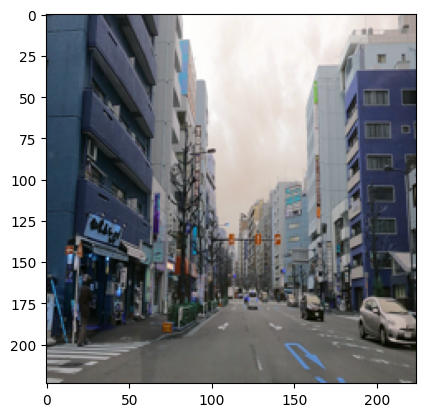

In [4]:
print(dataset.shape)
print(label.shape)


#Sanity check, view random few mages
import random
import numpy as np
image_number = random.randint(0, len(dataset)-1)
plt.imshow(np.reshape(dataset[image_number], (224, 224, 3)))
print("Label for this image is: ", label[image_number])

In [5]:
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

#from keras.utils import normalize
#X_train = normalize(X_train, axis=1)
#X_test = normalize(X_test, axis=1)
X_train = X_train / 255.
X_test = X_test / 255.

#Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0) #labels

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

## TRAINING MODEL

In [6]:
model_save_name = 'newdataset_ADNetclassifierkfold.pt'
path = f"/python_programming/FYP_2022/Models/{model_save_name}"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    verbose= 1,
    filepath=path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [7]:
ADNET_model = tf.keras.models.Sequential()
ADNET_model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu',  input_shape=SHAPE))
ADNET_model.add(tf.keras.layers.MaxPooling2D(2, 2))
ADNET_model.add(
    tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=3,
        strides=1,
        activation="relu"
    )
)
ADNET_model.add(tf.keras.layers.MaxPooling2D(2, 2)),
ADNET_model.add(tf.keras.layers.Conv2D(
        filters=256,
        kernel_size=3,
        strides=1,
        activation="relu",
        name="visualising_layer"
))

ADNET_model.add(tf.keras.layers.MaxPooling2D(2, 2))
ADNET_model.add(keras.layers.Flatten())
ADNET_model.add(keras.layers.Dense(units=1024, activation='relu'))
ADNET_model.add(keras.layers.Dropout(0.5))
ADNET_model.add(keras.layers.Dense(2, activation="softmax"))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
visualising_layer (Conv2D)   (None, 52, 52, 256)       147712    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 173056)            0

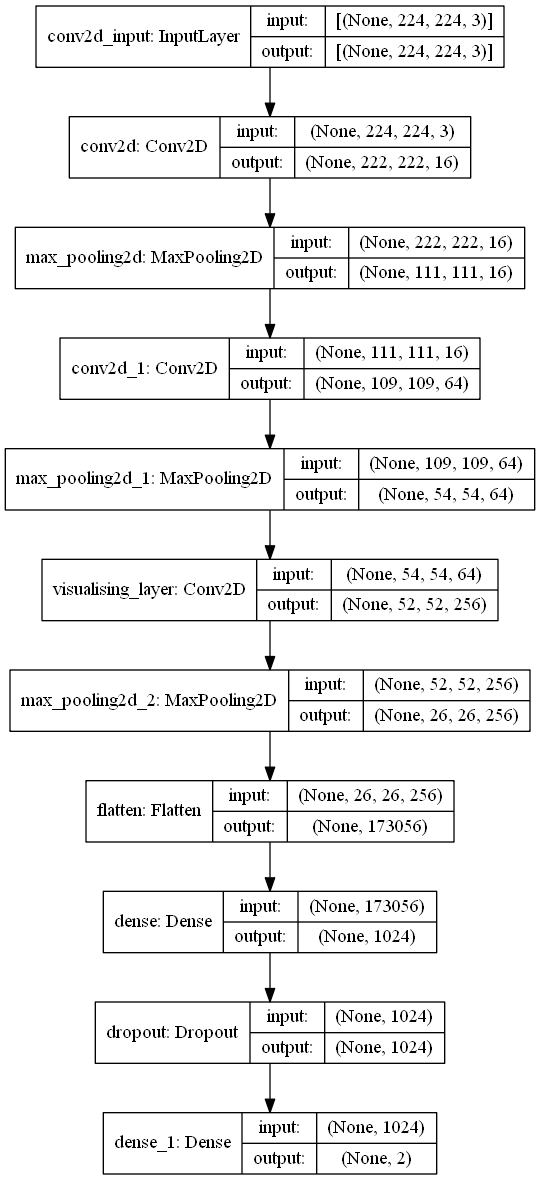

In [8]:
ADNET_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate= 0.00225, epsilon = 0.1),
        metrics=["accuracy"],
    )

print(ADNET_model.summary())
tf.keras.utils.plot_model(ADNET_model, show_shapes=True)#show_shapes=True

In [9]:
fold_no = 1

num_folds = 10  # Number of splits for k-fold cross-validation
kf = KFold(n_splits=num_folds)


for train, test in kf.split(inputs, targets):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history =ADNET_model.fit(
        X_train, y_train,
        validation_data=(X_test,y_test),
        batch_size=batch_size,
        epochs=50,
        steps_per_epoch=45,
        callbacks=[earlyStopping,model_checkpoint_callback]
    )

    # Generate generalization metrics
    scores = ADNET_model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {ADNET_model.metrics_names[0]} of {scores[0]}; {ADNET_model.metrics_names[1]} of {scores[1]}')
    acc_per_fold.append(scores[1]*100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
45/45 [==============================] - 10s 48ms/step - loss: 0.6640 - accuracy: 0.6125 - val_loss: 0.6349 - val_accuracy: 0.7277

Epoch 00001: val_accuracy improved from -inf to 0.72769, saving model to /python_programming/FYP_2022/Models\newdataset_ADNetclassifierkfold.pt
Epoch 2/50
45/45 [==============================] - 2s 38ms/step - loss: 0.5965 - accuracy: 0.6986 - val_loss: 0.5524 - val_accuracy: 0.7506

Epoch 00002: val_accuracy improved from 0.72769 to 0.75057, saving model to /python_programming/FYP_2022/Models\newdataset_ADNetclassifierkfold.pt
Epoch 3/50
45/45 [==============================] - 2s 42ms/step - loss: 0.5150 - accuracy: 0.7751 - val_loss: 0.4596 - val_accuracy: 0.7895

Epoch 00003: val_accuracy improved from 0.75057 to 0.78947, saving model to /python_programming/FYP_2022/Models\newdataset_ADNetclassifierkfold.pt
Epoch 4/50
45/45 [====================

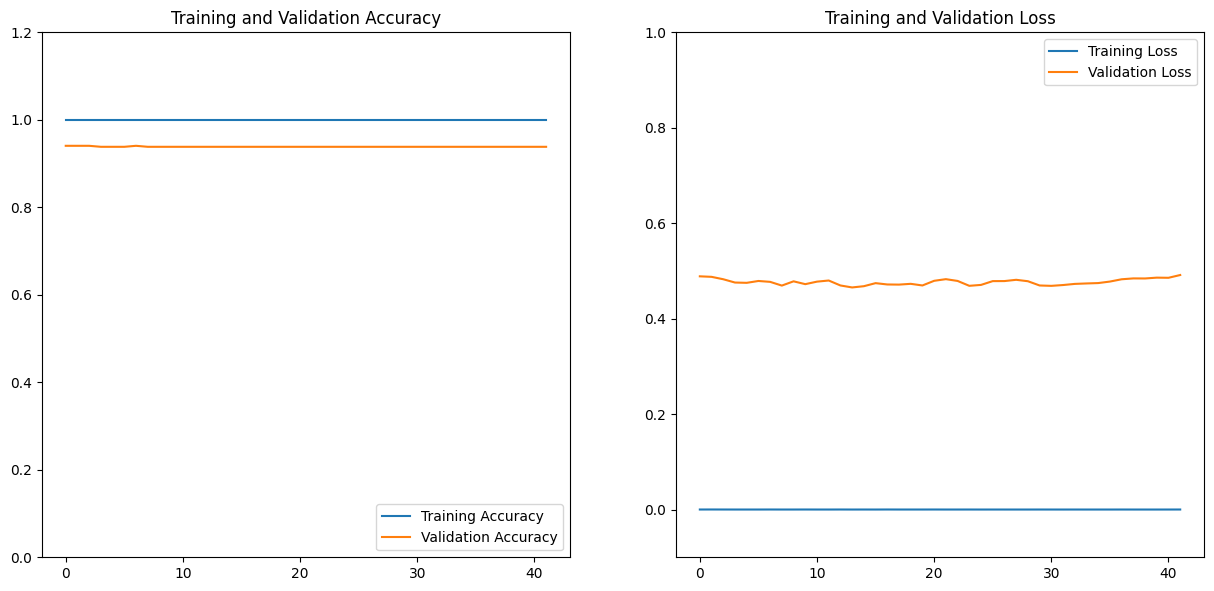

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.ylim(0, 1.2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.ylim(-0.1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## PREDICTIONS AND VISUALISATION OF MISCLASSIFIED IMAGES

In [11]:
ADNET_model.load_weights(path)

In [12]:
predictions = ADNET_model.predict(X_test)
actual_ylabel = y_test
#print("The prediction for this image is: ", predictions)
print("The actual label for this image is: ", actual_ylabel)

y_hat = np.argmax(predictions, axis = 1) # We take the highest probability
print('prediction label:', y_hat)

#Compare the predictions and labels and get the accuracy
accuracy = np.mean(np.equal(actual_ylabel, y_hat))
print(f"Accuracy: {accuracy:.2f}")



The actual label for this image is:  [1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1
 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1
 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0
 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1
 0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1
 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1
 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0
 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1
 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1
 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0
 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0
 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0]
prediction label: [1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0

In [13]:
_, acc = ADNET_model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


14/14 [==============================] - 0s 26ms/step - loss: 0.3208 - accuracy: 0.9474
Accuracy =  94.73684430122375 %


misclassified indices: [ 53  81  88  95 145 156 157 210 247 252 270 283 291 299 318 346 349 353
 363 368 375 407 426]
no. of misclassification: 23


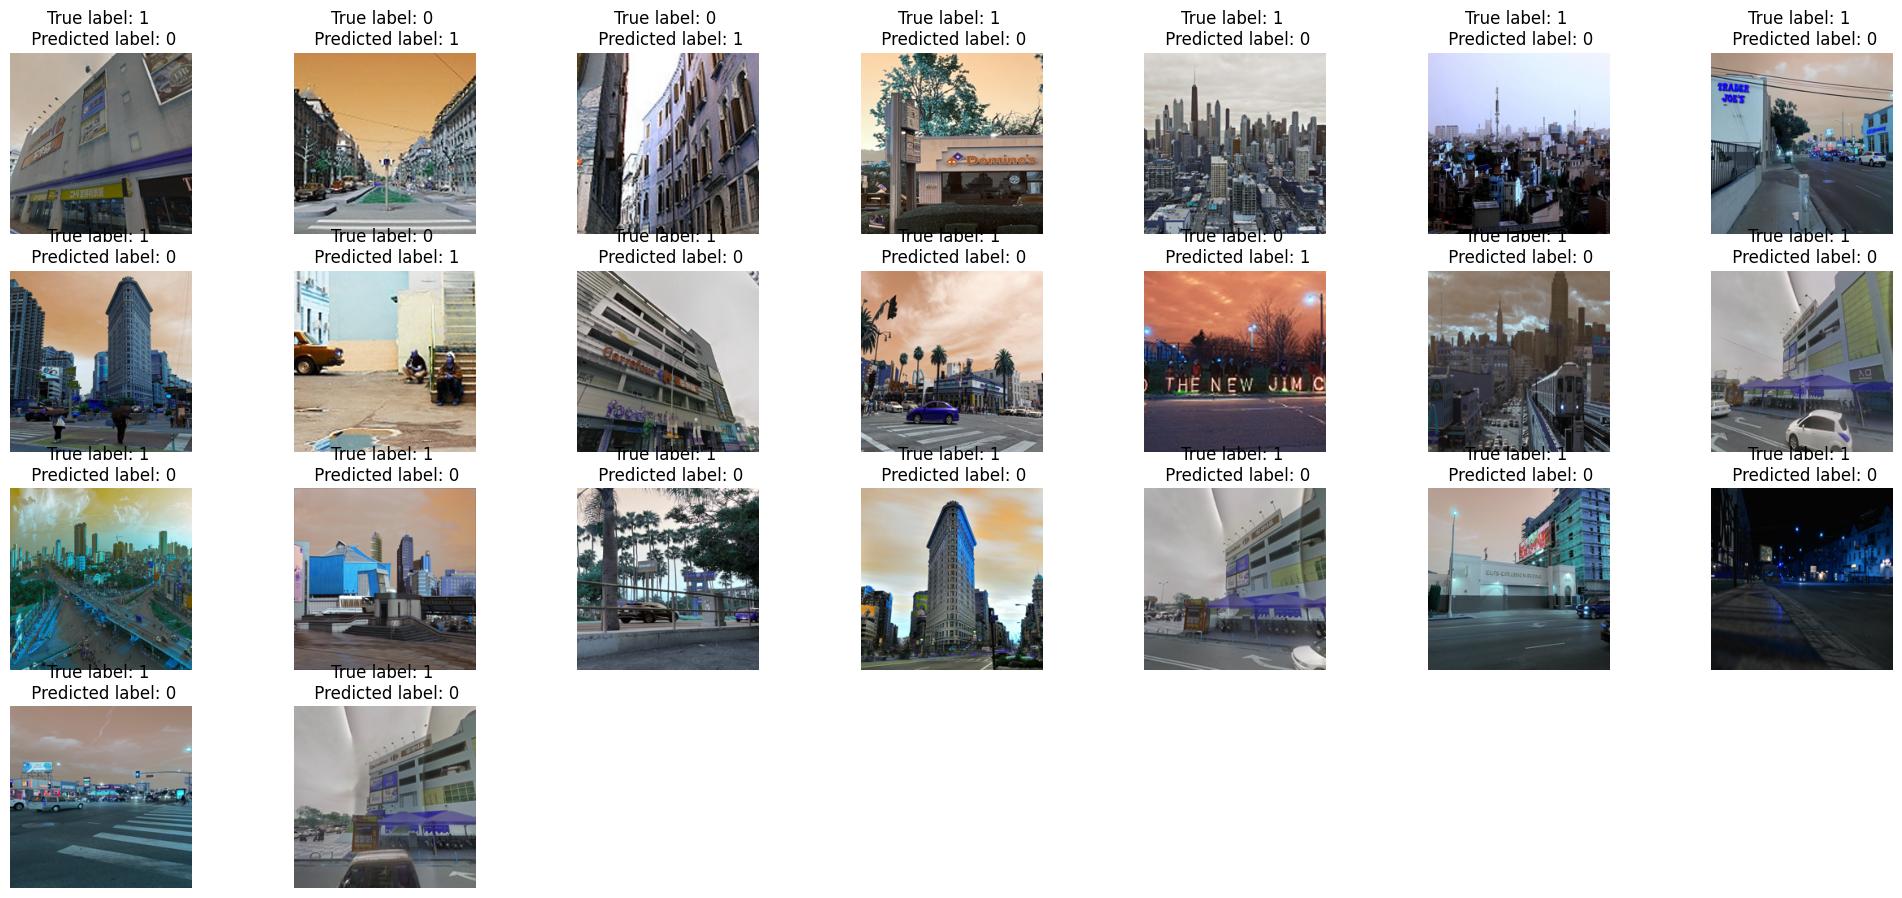

In [14]:
# Compare y_hat to y_val
misclassified = []
label_comparison =  actual_ylabel == y_hat
misclassified = np.where(label_comparison == False)[0]  # Get the indices of misclassified images
print('misclassified indices:',misclassified)
print('no. of misclassification:', len(misclassified))
plt.figure(figsize=(25, 25))
for i, index in enumerate(misclassified):
    ax =plt.subplot(9, 7, i+1)
    plt.imshow(X_test[index])
    plt.title("True label: {} \n Predicted label: {}".format(actual_ylabel[index], y_hat[index]))
    plt.axis('off')

Calculate evaluation metric: Precision, Recall, Accuracy, f1score

In [15]:
pre = tf.keras.metrics.Precision()
rec = tf.keras.metrics.Recall()
acc = tf.keras.metrics.BinaryAccuracy()
rootmsqrerror = tf.keras.metrics.RootMeanSquaredError()
auc_roc = tf.keras.metrics.AUC()

In [16]:
tf.math.confusion_matrix(
    y_test,
    y_hat,
    num_classes=2,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[174,   4],
       [ 19, 240]])>

In [17]:
pre.update_state(y_test, y_hat)
rec.update_state(y_test, y_hat)
acc.update_state(y_test, y_hat)
rootmsqrerror.update_state(y_test, y_hat)
auc_roc.update_state(y_test, y_hat)

print(f'Precision:{pre.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}')
print(f'RMSE:{rootmsqrerror.result().numpy()}')
print(f'AUC:{auc_roc.result().numpy()}')

f1_score = 2 * (pre.result().numpy() * rec.result().numpy()) / (pre.result().numpy() + rec.result().numpy())

print(f'F1score:{f1_score}')

Precision:0.9836065769195557, Recall:0.9266409277915955, Accuracy:0.9473684430122375
RMSE:0.22941572964191437
AUC:0.9520845413208008
F1score:0.954274309833342


Save model

In [18]:
path = f"/python_programming/FYP_2022/Models/model/"
ADNET_model.save(os.path.join(path, 'newdatasetADNET_modelkfold.h5'))


In [19]:
path = f"/python_programming/FYP_2022/Models/model/"
new_model = tf.keras.models.load_model(os.path.join(path, 'newdatasetADNET_modelkfold.h5'))

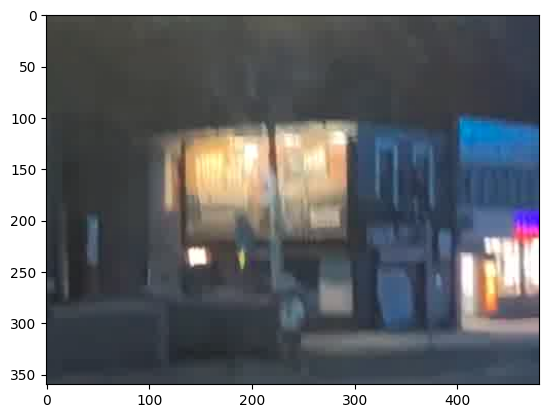

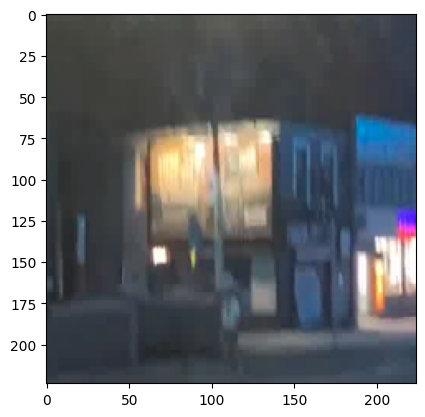

[[6.7506704e-07 9.9999928e-01]]
[1]
Predicted class belongs to billboard class


In [21]:
newtest = cv2.imread('/python_programming/FYP_2022/new_billboard_dataset/Billboard/0059 (2).jpg')
plt.imshow(newtest)
plt.show()

resize_newtest = cv2.resize(newtest, (224, 224))
plt.imshow(resize_newtest)
plt.show()
pred_newtest = np.expand_dims(resize_newtest/255, 0)
#print(pred_newtest)

y_pred_newtest = new_model.predict(pred_newtest)
print(y_pred_newtest)
y_pred_newtest = np.argmax(y_pred_newtest, axis = 1)
print(y_pred_newtest)

if y_pred_newtest > 0.5:
  print('Predicted class belongs to billboard class')

else:
  print('Predicted class belongs to no billboad class')